# Image Assembly

Raw ScanImage `.tiff` files are saved to disk in an interleaved manner. The general workflow is as follows:

- Set up filepaths.

- Initialize a [scanreader](https://github.com/atlab/scanreader/tree/master) object to read in raw .tiff files.

- Save the assembled image **or** individual ROIs to disk.

In [20]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import tifffile

import fastplotlib as fpl

import matplotlib.pyplot as plt

# import scanreader as sr
import lbm_caiman_python as lcp

import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (12, 8),
    'ytick.major.left': True,
})
jet = mpl.colormaps['jet']
jet.set_bad(color='k')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Input data: Path to your raw .tiff file(s)

Before processing, ensure:
- Put all raw `.tiff` files, from a single imaging session, into a directory. 
    - Here, we name that directory `raw`
- No other `.tiff` files reside in this directory

There are a few ways to pass your raw files into the scanreader.

1) A string containing a wildcard pattern for files to gather:
2) A list of strings containing all files in that directory.

## Initialize a scanreader object

(Option 1). Simply pass a string containing a wildcard pattern for files to gather
```{code-block} python
files = "C:/Users/RBO/caiman_data/raw/*.
scan = sr.read_scan(files, join_contiguous=True)
```

(Option 2). Manually gather a list of strings containing all `.tiff` files in that directory
```{code-block} python
parent_dir = Path().home() / 'caiman_data' / 'raw'
raw_tiff_files = [str(x) for x in parent_dir.glob("*.tif*")]
scan = sr.read_scan(raw_tiff_files, join_contiguous=True)
```

In [11]:
data_path = r"C:\Users\RBO\lbm_data\raw\MH70_0p6mm_FOV_50_550um_depth_som_stim_199mW_3min"
files = lcp.get_files_ext(data_path, str_contains='tif', max_depth=1)

## scanreader object

When indexing the scanreader, a numpy array is returned with dimensions `[field, T, z, y, x]`

- If `join_contiguous=True`, the scanreader object will have only 1 field, as all ROIs are joined into a single field.

- If `join_contiguous=False`, the scanreader object will have multiple fields, each corresponding to a single ROI.

This example does not cover the case where you separate your image by ROI.

In [21]:
scan = lcp.read_scan(files, join_contiguous=True)

In [22]:
print(f'Planes: {scan.num_channels}')
print(f'Frames: {scan.num_frames}')
print(f'ROIs: {scan.num_rois}')
print(f'Fields: {scan.num_fields}')  # 1, because join_contiguous=True

Planes: 30
Frames: 1730
ROIs: 4
Fields: 1


You can use the scan object as if it were a numpy array

In [26]:
array = scan[:100, 0, :, :]
# 4 fields (join_contiguous=False), one for each ROI
print(f'[T, y, x]: {array.shape} (with the first 100 frames')

[T, y, x]: (100, 600, 576) (with the first 100 frames


In [28]:
array = scan[:100, 1:3, :, :]
# 4 fields (join_contiguous=False), one for each ROI
print(f'[T, z, y, x]: {array.shape} (with the first 100 frames')

[T, z, y, x]: (100, 2, 600, 576) (with the first 100 frames


In [30]:
del array

### View a single z-plane timeseries

You can pass in the scan object to preview your data before saving it to disk.

```{warning}
Make sure you set histogram_widget=False or you will get an index error.
```

RFBOutputContext()

JupyterRenderCanvas(css_height='560.0px', css_width='900.0px')
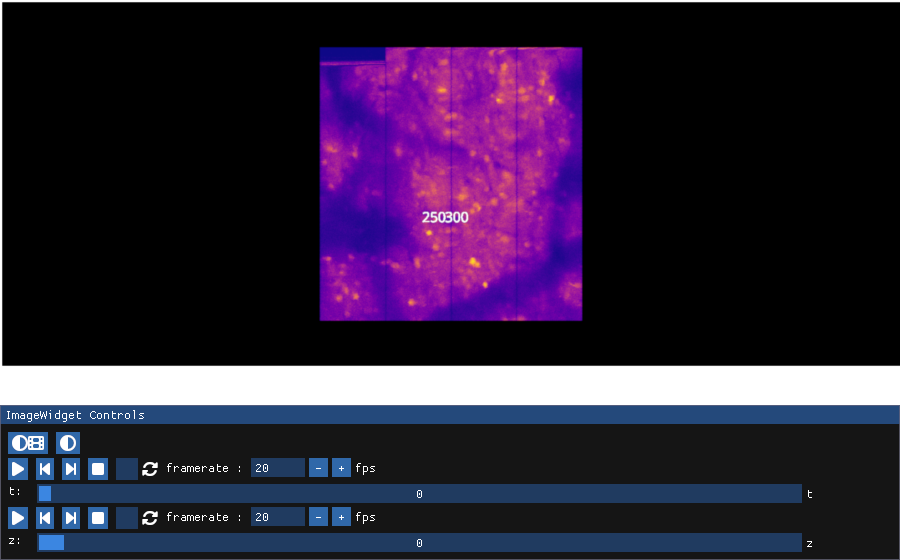

In [32]:
image_widget = fpl.ImageWidget(scan, histogram_widget=False,  figure_kwargs={"size": (900, 560)},)
image_widget.figure[0, 0].auto_scale()
image_widget.show()

In [19]:
image_widget.close()

### Include more z-planes for a 4D graphic

## Path to save your files

We can save the assembled image or individual ROIs to disk. The currently supported file extensions are `.tiff` (for now).

```{note}
For `.zarr` files to be compatible with caiman, we need to control the filenames.

Each z-plane sent through caiman needs a `.zarr` extension, and to be further compatible with caiman locating the dataset we need to further add a `mov` subdirectory to mimic compatibility hdf5 groups.

This is a CaImAn specific quirk, and we suggest sticking with `.tiff` to avoid any future incompatibilities with CaImAn updates.
```


In [39]:
save_path = r"C:\Users\RBO\lbm_data\processed"

We pass our scan object, along with the save path into `lbm_caiman_python.save_as()`

```{important}
If you initialize the scanreader with `join_contiguous=False`, filename structure will be `plane_{plane}_roi_{roi}{str}.tiff`
If you initialize the scanreader with `join_contiguous=True`, filename structure will be `plane_{plane}{str}.tiff`
... where `str` is the paramter `append_str`
```

In [52]:
# We recommend discarding the first frame if it contains extra flyback lines.
lcp.save_as(scan, save_path, overwrite=True, append_str="_assembled", ext='.tiff')

Reading tiff series data...
Reading tiff pages...
Raw tiff fully read.
Saving 30 planes.


Saving planes: 100%|██████████████████████████████| 30/30 [02:30<00:00,  5.02s/it]

Data successfully saved to C:\Users\RBO\lbm_data\processed.


### Read back in your file to make sure it saved properly

In [46]:
img = tifffile.imread(Path(save_path) / 'plane_1.tiff')
img.shape

(499, 600, 576)

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
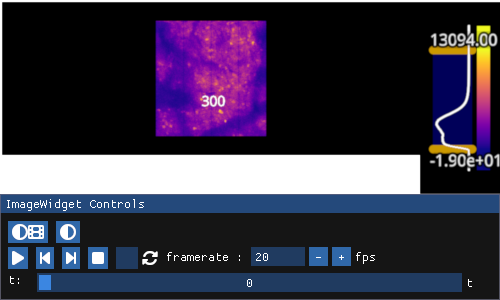

In [47]:
image_widget = fpl.ImageWidget(img)
image_widget.show()

In [38]:
image_widget.close()

### Preview raw traces

We can also preview the raw traces of the assembled image.

Click on a pixel to view the raw trace for that pixel over time.

In [45]:
from ipywidgets import VBox
iw_movie = fpl.ImageWidget(img, cmap="viridis")

tfig = fpl.Figure()

raw_trace = tfig[0, 0].add_line(np.zeros(img.shape[0]))

@iw_movie.managed_graphics[0].add_event_handler("click")
def pixel_clicked(ev):
    col, row = ev.pick_info["index"]
    raw_trace.data[:, 1] =  iw_movie.data[0][:, row, col]
    tfig[0, 0].auto_scale(maintain_aspect=False)

VBox([iw_movie.show(), tfig.show()])

RFBOutputContext()

RFBOutputContext()